In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import json
import os
import random
import sys
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch
import time
import torch.nn as nn
from tqdm import tqdm
import time
import numpy as np
import torch
import networkx as nx
import random
import math



In [3]:
agents = [2,4,8]
goals = [0,1,5,10]
MAPF = "CBS"
SAPF = "TDSP"
costFunction = "SIC"
heuristic = ""


def drawGraph(G):
    labeldict = {}
    for node in G.nodes:
        labeldict[node] = G.nodes[node]["name"]

    plt.figure(figsize=(4096/90, 2160/90))
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, nx.get_node_attributes(G, 'pos'), edge_labels=labels)
    nx.draw(G, nx.get_node_attributes(G, 'pos'), labels = labeldict, with_labels=True, node_size = 100, font_size = 3)
    plt.show()


def saveGraphImage(filename, G):
    labeldict = {}
    for node in G.nodes:
        labeldict[node] = G.nodes[node]["name"]

    labels = nx.get_edge_attributes(G,'weight')
    plt.figure(figsize=(4096/90, 2160/90))
    nx.draw_networkx_edge_labels(G,nx.get_node_attributes(G, 'pos'),edge_labels=labels)
    nx.draw(G, nx.get_node_attributes(G, 'pos'), labels = labeldict, with_labels=True, node_size = 10000, font_size = 20)
    plt.savefig(filename+".pdf", dpi = 1200, orientation = "landscape", transparent = False)
    # plt.savefig(filename+".png", dpi = 1200, orientation = "landscape", transparent = False)


def getGraphFromJson(filename = "graph.json"):
    G = nx.DiGraph()
    with open (filename, "r") as fileJson:
        data = json.load(fileJson)
        for v in data["nodes"]:
            G.add_node(v[1], pos=(v[2], v[3]), name=v[0])

        for row in range(len(data["connect"])):
            for col in range(len(data["connect"][row])):
                if data["connect"][row][col] == 1:
                    G.add_edge(row, col, weight=data["connect"][row][col])

    # Add links to make it connected
    # G.add_edge(135, 144, weight=1)
    # G.add_edge(143, 145, weight=1)
    # G.add_edge(161, 162, weight=1)
    # G.add_edge(173, 174, weight=1)
    # G.add_edge(185, 186, weight=1)
    # G.add_edge(144, 135, weight=1)
    # G.add_edge(145, 143, weight=1)
    # G.add_edge(162, 161, weight=1)
    # G.add_edge(174, 173, weight=1)
    # G.add_edge(186, 185, weight=1)

    drawGraph(G)
    return G


def extractBuilding1(G : nx.DiGraph):
    if not os.path.isdir("maps/build1"):
        os.mkdir("maps/build1")

    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] < 74:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/build1/build1", build)
    if nx.is_strongly_connected(build):
        print("Build1 connected")
    else:
        print("Build 1 not connected")

    return build


def extractBuilding2(G : nx.DiGraph):
    if not os.path.isdir("maps/build2"):
        os.mkdir("maps/build2")
    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] > 109:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/build2/build2", build)
    if nx.is_strongly_connected(build):
        print("Build 2 connected")
    else:
        print("Build 2 not connected")

    return build



def extractBridge(G : nx.DiGraph):
    if not os.path.isdir("maps/bridge"):
        os.mkdir("maps/bridge")
    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] < 109 and G.nodes[node]["pos"][0] > 73:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/bridge/bridge", build)
    if nx.is_strongly_connected(build):
        print("Bridge connected")
    else:
        print("Bridge not connected")

    return build


def createRandom(G : nx.DiGraph, outputDir : str):
    if not os.path.isdir(outputDir):
        os.mkdir(outputDir)

    data = dict()
    data["MAPF"] = MAPF
    data["SAPF"] = SAPF
    data["costFunction"] = costFunction
    data["heuristic"] = heuristic
    data["nNodes"] = len(G.nodes)
    data["nodes"] = []
    for node in G.nodes:
        data["nodes"].append((G.nodes[node]["name"], G.nodes[node]["pos"][0], G.nodes[node]["pos"][1], node))
    data["connect"] = nx.adjacency_matrix(G, nodelist=sorted(G.nodes)).todense().tolist()

    counter = 0

    for nAgents in agents:
        if nAgents >= len(data["nodes"]):
            print("Skipping nAgents = " + str(nAgents) + " because it is too big")
            continue
        data["nAgents"] = nAgents
        data["agents"] = [{} for a in range(nAgents)]
        initPos = random.sample(list(data["nodes"]), nAgents)
        endPos = []
        if nAgents > 50 * len(data["nodes"]) / 100.0:
            endPos = initPos
        else:
            endPos = random.sample([n for n in data["nodes"] if n not in initPos], nAgents)

        for a in range(nAgents):
            data["agents"][a]["ID"] = a
            data["agents"][a]["initPos"] = initPos[a]
            data["agents"][a]["endPos"] = endPos[a]

        for nGoals in goals:
            nonEndPos = [n for n in data["nodes"] if n not in endPos]
            for a in range(nAgents):
                data["agents"][a]["goalPos"] = []
                if nGoals > 0:
                    data["agents"][a]["goalPos"].append(random.choice(nonEndPos))
                for i in range(1, nGoals):
                    tmp = random.choice(nonEndPos)
                    while tmp == data["agents"][a]["goalPos"][-1]:
                        tmp = random.choice(nonEndPos)
                    data["agents"][a]["goalPos"].append(tmp)

            # Make sure that no goalPos is also an endPos
            for a in range(nAgents):
                for n in data["agents"][a]["goalPos"]:
                    if n in endPos:
                        raise Exception("goalPos is already an endPos")

            with open("temp.json", "w+") as output:
                json.dump(data, output, indent = 2)

            with open("temp.json", "r") as temp:
                with open(os.path.join(outputDir, str(counter)+".json"), "w+") as output:
                    for line in temp:
                        if any(x in line for x in ["{" , "}", "nNodes", "nodes", "connect", "]", "MAPF", "SAPF", "costFunction", "heuristic", "nAgents", "ID", "goalPos"]):
                            output.write(line)
                        else:
                            line = line.split("\n")[0]
                            output.write(line)

            os.remove("temp.json")

            counter += 1
            print(counter, end="\r")


if __name__ == "__main__":
    random.seed(1)  # for repeatability
    if not os.path.isdir("maps"):
        os.mkdir("maps")
    if not os.path.isdir("maps/uni"):
        os.mkdir("maps/uni")

    # G = getGraphFromJson()
    # createRandom(G, "maps/uni/output")
    # build1 = extractBuilding1(G)
    # createRandom(build1, "maps/build1/output")
    # bridge = extractBridge(G)
    # createRandom(bridge, "maps/bridge/output")
    # build2 = extractBuilding2(G)
    # createRandom(build2, "maps/build2/output")


In [4]:
class Agent:
    def __init__(self, data,num_nodes,shortest_path_lengths,map):
        self.id = data["ID"]
        if map == "uni":
            self.init_pos = data["initPos"][0]
            self.end_pos = data["endPos"][0]
            self.goal_pos = data["goalPos"][0] if len(data["goalPos"])>0 else None
        else:
            self.init_pos = data["initPos"][1]
            self.end_pos = data["endPos"][1]
            self.goal_pos = data["goalPos"][0] if len(data["goalPos"])>0 else None
        self.num_nodes=num_nodes
        self.current_pos = self.init_pos
        self.window_size=10
        self.path = [self.init_pos]
        self.shortest_path_lengths = shortest_path_lengths
    def __str__(self):
        return f"Agent(id={self.id}, init_pos={self.init_pos}, end_pos={self.end_pos}, goal_pos={self.goal_pos})"
    def get_id(self):
        return self.id
    def get_init_pos(self):
        return self.init_pos
    def get_end_pos(self):
        return self.end_pos
    def get_current_pos(self):
        return self.current_pos
    def get_enc_end_pos(self):
        encoded_end_pos=np.zeros(self.num_nodes)
        encoded_end_pos[self.end_pos]=1
        return encoded_end_pos
    def get_enc_current_pos(self):
        encoded_current_pos=np.zeros(self.num_nodes)
        encoded_current_pos[self.current_pos]=1
        return encoded_current_pos
    
    def get_prev_path(self):
        return self.path
    def get_goal_pos(self):
        return self.goal_pos
    def update_path(self, new_node):
        # self.path=self.path[1:]
        self.path.append(new_node)
        self.current_pos = new_node

    def get_collision(self, agent_list):
        collision = []
        for agent in agent_list:
            if agent.get_id() != self.get_id():
                if agent.get_current_pos() == self.get_current_pos():
                    collision.append(agent.get_id())
        
        return 1 if len(collision)>0 else 0

    def get_distance_towards_agents(self, agent_list):
        distance = []
        for agent in agent_list:
                # distance.append(nx.shortest_path_length(G, self.get_current_pos(), agent.get_current_pos(), weight='weight'))
                distance.append(self.shortest_path_lengths[self.get_current_pos()][agent.get_current_pos()])
        return distance
    def get_occupancy(self, graph,agent_list):
        graph_nodes=np.zeros(self.num_nodes)
        for agent in agent_list:
            graph_nodes[agent.get_current_pos()]=1
        return graph_nodes

    def get_features(self, graph, agent_list):
        '''
        returns features for agent in the following order:
        1. one hot encoding of current position
        2. one hot encoding of end position
        3. past movement of agent
        4. collision with other agents
        5. distance towards other agents
        6. blocked nodes
        '''
        features= np.hstack((self.get_enc_current_pos(), self.get_enc_end_pos(), self.get_prev_path(), [self.get_collision( agent_list)], 
                             self.get_distance_towards_agents(agent_list), self.get_occupancy(graph, agent_list)))
        return torch.tensor(features).float()
    

    
    def generate_node_features(self, num_nodes, adjacency_matrix, agent_list,G, path_decay=0.9):
        """
        Creates input feature vector for a given agent.
        Includes path memory and distance to other agents.
        """
        # features = np.zeros((num_nodes, 7))  # Feature matrix [num_nodes, num_features]
        
        # for node in range(num_nodes):
        #     # 1. One-hot encoding of current position
        #     features[node, 0] = 1 if node == self.get_current_pos() else 0
            
        #     # 2. One-hot encoding of goal position
        #     features[node, 1] = 1 if node == self.get_end_pos() else 0
            
        #     # 3. Distance to goal (normalized)
        #     # features[node, 2] = nx.shortest_path_length(G, node, self.get_end_pos(), weight='weight') / num_nodes
        #     features[node, 2] = self.shortest_path_lengths[node][self.get_end_pos()] / num_nodes
        #     # 4. Path memory (decaying influence of previous visited nodes)
        #     features[node, 3] = path_decay ** self.get_prev_path().count(node) if node in self.get_prev_path() else 0
            
        #     # 5. Collision information (1 if occupied, 0 otherwise)
        #     features[node, 4] = 1 if any(a.get_current_pos() == node for a in agent_list) else 0
            
        #     # 6. Neighbor occupancy (checks if adjacent nodes are occupied)
        #     features[node, 5] = np.sum([1 for neighbor in np.nonzero(adjacency_matrix[node])[0] 
        #                                 if any(a.get_current_pos() == neighbor for a in agent_list)])
            
        #     # 7. Distance to other agents (min distance to any agent)
        #     # distances =[nx.shortest_path_length(G, node, a.get_current_pos(), weight='weight') for a in agent_list if a.get_id() != self.get_id()] 
        #     distances= [self.shortest_path_lengths[node][a.get_current_pos()] for a in agent_list if a.get_id() != self.get_id()]
        #     features[node, 6] = min(distances) / num_nodes if distances else 1  # Normalize by num_nodes
        features = torch.zeros((num_nodes, 7))
        agent_positions = set(a.get_current_pos() for a in agent_list) 
        current_node = self.get_current_pos()
        goal_node = self.get_end_pos()
        prev_path = self.get_prev_path()

        features[:, 0] = torch.tensor([1 if i == current_node else 0 for i in range(num_nodes)])
        features[:, 1] = torch.tensor([1 if i == goal_node else 0 for i in range(num_nodes)])
        features[:, 2] = torch.tensor([self.shortest_path_lengths[i][goal_node] / num_nodes for i in range(num_nodes)])
        features[:, 3] = torch.tensor([path_decay ** prev_path.count(i) if i in prev_path else 0 for i in range(num_nodes)])
        features[:, 4] = torch.tensor([1 if i in agent_positions else 0 for i in range(num_nodes)])
        return features
        # return torch.tensor(features, dtype=torch.float32)



    def __repr__(self):
        return f"Agent(id={self.id}, init_pos={self.init_pos}, end_pos={self.end_pos}, goal_pos={self.goal_pos})"

In [ ]:


# Linear Layer with Hebbian learning
class HebbianLinear(nn.Module):
    def __init__(self, in_features, out_features, lr=0.01,adj_matrix=None,A=0.1,B=0.1,C=0.01,D=0.01):
        super().__init__()
        self.adj_matrix=adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
        self.weight = nn.Parameter(torch.rand(in_features, out_features).to("cuda" if torch.cuda.is_available() else "cpu") *self.adj_matrix, requires_grad=False)
        self.lr = lr
        self.A=A
        self.B=B
        self.C=C
        self.D=D
    def forward(self, x):
        self.last_input = x.detach()  # store for update
        out = F.linear(x, self.weight)
        self.last_output = out.detach()
        return out
    def hebbian_update(self,reward):
        # Apply basic Hebbian rule
        pre = self.A*self.last_input
        post = self.B*self.last_output
        C_part = self.C*pre*post
        dw= pre + post + C_part + self.D
        
        oja_decay = self.lr * (post ** 2) * self.weight.data
        dw = dw - oja_decay
        self.weight.data += (np.sign(reward))*self.lr*(dw*self.adj_matrix) #- decay_param* self.weight.data
        # Normalize weights using Min-Max scaling to range [-1, 1]

# Graph NN layer with Hebbian learning
class HebbianGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, lr=0.01,adj_matrix=None,A=0.1,B=0.1,C=0.01,D=0.0001):
        super().__init__()
        self.adj_matrix = adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
        self.linear = HebbianLinear(in_channels, out_channels, lr,self.adj_matrix, A, B, C, D)
        self.lr = lr
        self.A=A
        self.B=B
        self.C=C
        self.D=D
        self.dimension=adj_matrix.shape[0]
        self.aggregation_weight = nn.Parameter(torch.ones(self.dimension, self.dimension).to("cuda" if torch.cuda.is_available() else "cpu") *0.01*self.adj_matrix, requires_grad=False)
    def forward(self, x, edge_index):
        # Basic GCN-style aggregation (mean over neighbors)
        agg = torch.zeros_like(x)
        batch_size, num_nodes, _ = x.size()
        for i in range(batch_size):
            row, col = edge_index
            weighted_x = x[i] * self.aggregation_weight
            deg = torch.bincount(row, minlength=x[i].size(0)).clamp(min=1).float().unsqueeze(1)
            agg[i].index_add_(0, row, weighted_x[col])
            agg[i] = agg[i] / deg
        return self.linear(agg)

    def hebbian_update(self,reward,current_node,next_node):
        # Apply Hebbian update to the aggregation weights
        if (reward.shape == 1 and reward[0]<0.0) or any(reward<0.0) :
            pre = self.A*self.linear.last_input
            post = self.B*self.linear.last_output
            C_part = self.C*pre*post
            dw= pre + post + C_part + self.D
            oja_decay =  (post ** 2) * self.aggregation_weight.data
            dw = dw - oja_decay
            # self.aggregation_weight.data[current_node,next_node] +=reward*dw[current_node,next_node]
            for i in range(reward.shape[0]):
                if reward[i]:
                    self.aggregation_weight.data[next_node,current_node] +=reward[i]*dw[i,next_node,current_node]
        # self.linear.hebbian_update(reward)
 

# MLP to get final predictions from GNN output
class HebbianMLP(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, eta=0.1,adj_matrix=None,A=0.1,B=0.1,C=0.01,D=0.01):
        super().__init__()
        self.A= A
        self.B= B
        self.C= C
        self.D= D
        self.eta=eta
        self.adj_matrix = adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
        self.mlp = nn.Sequential(
            # HebbianLinear(in_channels, hidden_dim, eta,adj_matrix,A,B,C,D),
            HebbianLinear(hidden_dim, out_channels, eta,adj_matrix,A,B,C,D),  # Logits over all nodes
            # nn.Tanh(),
        
        )

        

    def forward(self, x,current_node):

        x = self.mlp(x[current_node])
       # x = F.softmax(x, dim=1)  # Apply softmax to get probabilities
        
        return x # Return the index of the max value
    def hebbian_update(self, reward, chosen_action_idx,next_node):
        # First layer update (optional)
        # pre = self.A * self.mlp[0].last_input.detach()        # [in_dim]
        # post = self.B * self.mlp[0].last_output.detach()      # [hidden_dim]
        # C_part = self.C * pre.unsqueeze(0) * post.unsqueeze(1)  # Outer product
        # dw = pre.unsqueeze(0) + post.unsqueeze(1) + C_part + self.D
        # oja_decay = (post ** 2).unsqueeze(1) * self.mlp[0].weight.data
        # delta = reward * (dw - oja_decay)
        
        # # Apply to all weights of first layer
        # self.mlp[0].weight.data += delta
        
        if len(reward) == 1:
            last_layer = self.mlp[0]
            pre_val = last_layer.last_input.detach()[chosen_action_idx]  # Typically 1 for the current state.
            post_val = last_layer.last_output.detach()[next_node]
            hebb_term = self.A * pre_val + self.B * post_val + self.C * (pre_val * post_val) + self.D
            decay_parameter=0.1
            # Oja's decay term to keep the weight from growing without bound.
            oja_decay = (post_val ** 2) * last_layer.weight.data[next_node, chosen_action_idx]
        
        # The overall weight change. If reward is negative, delta will be negative.
            delta = reward[0] * (hebb_term - decay_parameter*oja_decay)
            last_layer.weight.data[next_node, chosen_action_idx] += delta
        else:    
            for i in range(len(reward)):

                last_layer = self.mlp[0]
                pre_val = last_layer.last_input.detach()[chosen_action_idx[i]]  # Typically 1 for the current state.
                post_val = last_layer.last_output.detach()[next_node[i]]
                hebb_term = self.A * pre_val + self.B * post_val + self.C * (pre_val * post_val) + self.D
                decay_parameter=0.1
                # Oja's decay term to keep the weight from growing without bound.
                oja_decay = (post_val ** 2) * last_layer.weight.data[next_node[i], chosen_action_idx[i]]
            
            # The overall weight change. If reward is negative, delta will be negative.
                delta = reward[i] * (hebb_term - decay_parameter*oja_decay)
                last_layer.weight.data[next_node[i], chosen_action_idx[i]] += delta

        # Update only the connection from 'start_node' to 'chosen_node'
        # if next_node == chosen_action_idx:
        #     last_layer.weight.data[next_node, chosen_action_idx] += 2*delta
        #     last_layer.weight.data[:, chosen_action_idx] -= delta*self.adj_matrix[:, chosen_action_idx]
        # else:


# Main Hebbian GNN class
class HebbianGNN(nn.Module):
    def __init__(self, in_channels, hidden_dim, eta,adj_matrix, A=0.1, B=0.1, C=0.01, D=0.01):
        super().__init__()
        self.node_embed = nn.Linear(in_channels, hidden_dim)
        self.layer1 = HebbianGCNLayer(hidden_dim, hidden_dim, eta,adj_matrix, A, B, C, D)
        self.layer2 = HebbianGCNLayer(hidden_dim, hidden_dim, eta,adj_matrix, A, B, C, D)
        self.mlp = HebbianMLP(hidden_dim, hidden_dim, hidden_dim, eta,adj_matrix, A, B, C, D)

        self.A=A
        self.B=B
        self.C=C
        self.D=D
    def forward(self, x, edge_index,current_node):
        # Forward pass through each Hebbian layer
        batch_size, num_nodes, _ = x.size()
        output = torch.zeros(batch_size, num_nodes).to(x.device)  # Initialize output tensor
        # Apply embedding and activation

        x_embed = F.tanh(self.node_embed(x))  # [batch_size, num_nodes, hidden_dim]

        # GCN Layer 1
        x1 = self.layer1(x_embed, edge_index)
        x1 = F.tanh(x1)
        x1 = F.dropout(x1, p=0.7, training=self.training)

        # GCN Layer 2
        x2 = self.layer2(x1, edge_index)
        x2 = F.tanh(x2)
        x2 = F.dropout(x2, p=0.5, training=self.training)

        for i in range(batch_size):
        
        # MLP outputs per agent at their current position
            out = self.mlp(x2[i], current_node[i])  # [batch_size, num_nodes]
            output[i] = out
        # self.layer2.linear.last_input = x1
        # self.layer2.linear.last_output = x2
        # out = self.mlp(x2)
        # Apply activation function (e.g., ReLU, sigmoid)
        # out=F.softmax(out, dim=0)
        # The final output (e.g., decision for the agent)
        return output

    def update_weights(self,reward,current_node,next_node):
        # Apply Hebbian updates for all layers
        self.layer1.hebbian_update(reward,current_node,next_node)
        self.layer2.hebbian_update(reward,current_node,next_node)
        self.mlp.hebbian_update(reward,current_node,next_node)
        # print("Weight stats:", self.layer1.linear.weight.data.min().item(), self.layer1.linear.weight.data.max().item())
        # print("Weight stats:", self.layer2.linear.weight.data.min().item(), self.layer2.linear.weight.data.max().item())
 

In [ ]:
def euclidean_weight(dist):
    """Compute weight from distance using inverse weighting."""
    return 1.0 / (dist + 0.1)

# finds neighbours of a node (not already excluded)
def get_valid_neighbors(agent, graph, excluded_nodes):
    """
    Returns a list of neighboring nodes (as per the graph)
    that are valid for deviation.
    Excluded nodes is a list of nodes that should not be selected.
    """
    current_pos = agent.get_current_pos()
    # Get all neighbors using the graph's structure
    neighbors = list(graph.neighbors(current_pos))
    # Exclude nodes that are in the excluded list
    valid_neighbors = [n for n in neighbors if n not in excluded_nodes]
    return valid_neighbors

# Weighted random choice based on distance to goal
def weighted_random_choice(candidates, agent_goal, shortest_path_lengths):
    """
    Given candidate nodes, use the shortest path length from each candidate to the agent's goal 
    as a basis to compute weight (closer nodes get higher weight).
    """
    weights = []
    for candidate in candidates:
        # Get the estimated remaining distance using the precomputed shortest path lengths
        d = shortest_path_lengths[candidate][agent_goal]
        weights.append(euclidean_weight(d))
    total_weight = sum(weights)
    probabilities = [w/total_weight for w in weights]
    chosen = random.choices(candidates, probabilities)[0]
    return chosen

# Main train function
def train_hebbian(model, agents, graph, num_nodes, epochs=100):
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(graph))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    adj_matrix = nx.adjacency_matrix(graph).todense()
    adj_logits_matrix = torch.tensor(adj_matrix).float().to(device)

    for epoch in tqdm(range(epochs)):
        model.to(device)
        model.train()
        
        reward = torch.zeros(len(agents)).to(device)
        edge_index = torch.tensor(np.array(list(graph.edges)).T, dtype=torch.long).to(device)

        while not all(agent.get_current_pos() == agent.get_end_pos() for agent in agents):
            with torch.no_grad():
                collision_flags = np.zeros(len(agents), dtype=bool)
                excluded_nodes = []
                steps = np.zeros(len(agents), dtype=bool)
                aggregated_features = torch.stack([
                        agent.generate_node_features(num_nodes, adj_matrix, agents, graph) 
                        for agent in agents
                    ]).to(device)
                agent_positions = torch.tensor([agent.get_current_pos() for agent in agents]).to(device)

                while not all(steps):
                    

                    out = model(aggregated_features, edge_index, agent_positions)
                    mask = torch.stack([adj_logits_matrix[pos].bool() for pos in agent_positions])

                    for i in range(len(agents)):
                        if collision_flags[i]:
                            mask[i, excluded_nodes] = False
                            
                    masked_probs = torch.where(mask, out, torch.tensor(-float('inf')).to(device))
                    next_node = torch.argmax(masked_probs, dim=1)

                    success = [agent.get_current_pos() == agent.get_end_pos() for agent in agents]
                    for i, agent in enumerate(agents):
                        if success[i]:
                            if steps[i]:
                                continue
                            reward[i] = 1.0
                            steps[i] = True
                    
                    for i, agent in enumerate(agents):
                        if next_node[i].item() == agent.get_end_pos():
                            if steps[i]:
                                continue
                            reward[i] = 1.0
                            agent.update_path(next_node[i].item())
                            steps[i] = True
                    
                    # --- Collision detection ---
                    collision = np.zeros(len(agents), dtype=bool)
                    for a in range(len(agents)):
                        for b in range(len(agents)):
                            if success[a] or success[b]:
                                continue
                            if a != b:
                                collision[a] = collision[a] or \
                                    (next_node[a] == next_node[b] or 
                                     next_node[a] == agents[b].get_current_pos())

                    if any(collision):
                        for i, agent in enumerate(agents):
                            if success[i]:
                                continue
                            if collision[i] and not collision_flags[i]:
                                
                                candidates = get_valid_neighbors(agent, graph, excluded_nodes)                                
                                if candidates:
                                    
                                    alternative_move = weighted_random_choice(candidates, agent.get_end_pos(), shortest_path_lengths)
                                    next_node[i] = torch.tensor(alternative_move).to(device)
                                    excluded_nodes.append(alternative_move)
                                    agent.update_path(alternative_move)
                                    steps[i] = True
                                
                                else:

                                    print(f"Agent {agent.get_id()} has no alternative. Waiting.")
                                    next_node[i] = torch.tensor(agent.get_current_pos()).to(device)
                                
                                collision_flags[i] = True
                            
                    # --- Movement based on improvement toward goal ---
                    for i, agent in enumerate(agents):
                        if steps[i]:
                            continue 

                        prev_dist = shortest_path_lengths[agent.get_current_pos()][agent.get_end_pos()]
                        curr_dist = shortest_path_lengths[next_node[i].item()][agent.get_end_pos()]
                        
                        if curr_dist < prev_dist:
                            reward[i] = 0.7
                            agent.update_path(next_node[i].item())
                            steps[i] = True
                            collision_flags[i] = False
                        
                        elif agent.get_current_pos() == next_node[i].item() and curr_dist == prev_dist:
                            reward[i] = -0.3
                           
                        else:
                            reward[i] = -0.5
                    
                    model.update_weights(reward, agent_positions, next_node.cpu().numpy())
                
                # For debug: print current and previous steps' distances.
                # for i, agent in enumerate(agents):

                #     prev_dist = shortest_path_lengths[agent.get_prev_path()[-2]][agent.get_end_pos()]
                #     curr_dist = shortest_path_lengths[next_node[i].item()][agent.get_end_pos()]
                #     print("agent:", agent.get_id())
                #     if success[i]:
                #         print("Reached goal:", agent.get_end_pos())
                #     else:
                #         print("From node:", agent.get_prev_path()[-2], "to:", next_node[i].item())
                #         print("Distances:", prev_dist, curr_dist)
        
    for agent in agents:
        print(agent.get_id(), agent.get_prev_path())

# used whnever I have a non-connected graph
def connect_graph(G):
    components = list(nx.strongly_connected_components(G))
    representatives = [list(comp)[0] for comp in components]
    for i in range(len(representatives) - 1):
        G.add_edge(representatives[i], representatives[i + 1])

def remove_random_edges_while_connected(graph, num_edges_to_remove):
    """
    Removes a specified number of edges randomly from the graph while ensuring it remains strongly connected.
    """
    edges = list(graph.edges)
    random.shuffle(edges) 
    removed_edges = 0

    for edge in edges:
        graph.remove_edge(*edge)
        if not nx.is_strongly_connected(graph):
            graph.add_edge(*edge)
        else:
            removed_edges += 1
        if removed_edges == num_edges_to_remove:
            break

    return graph



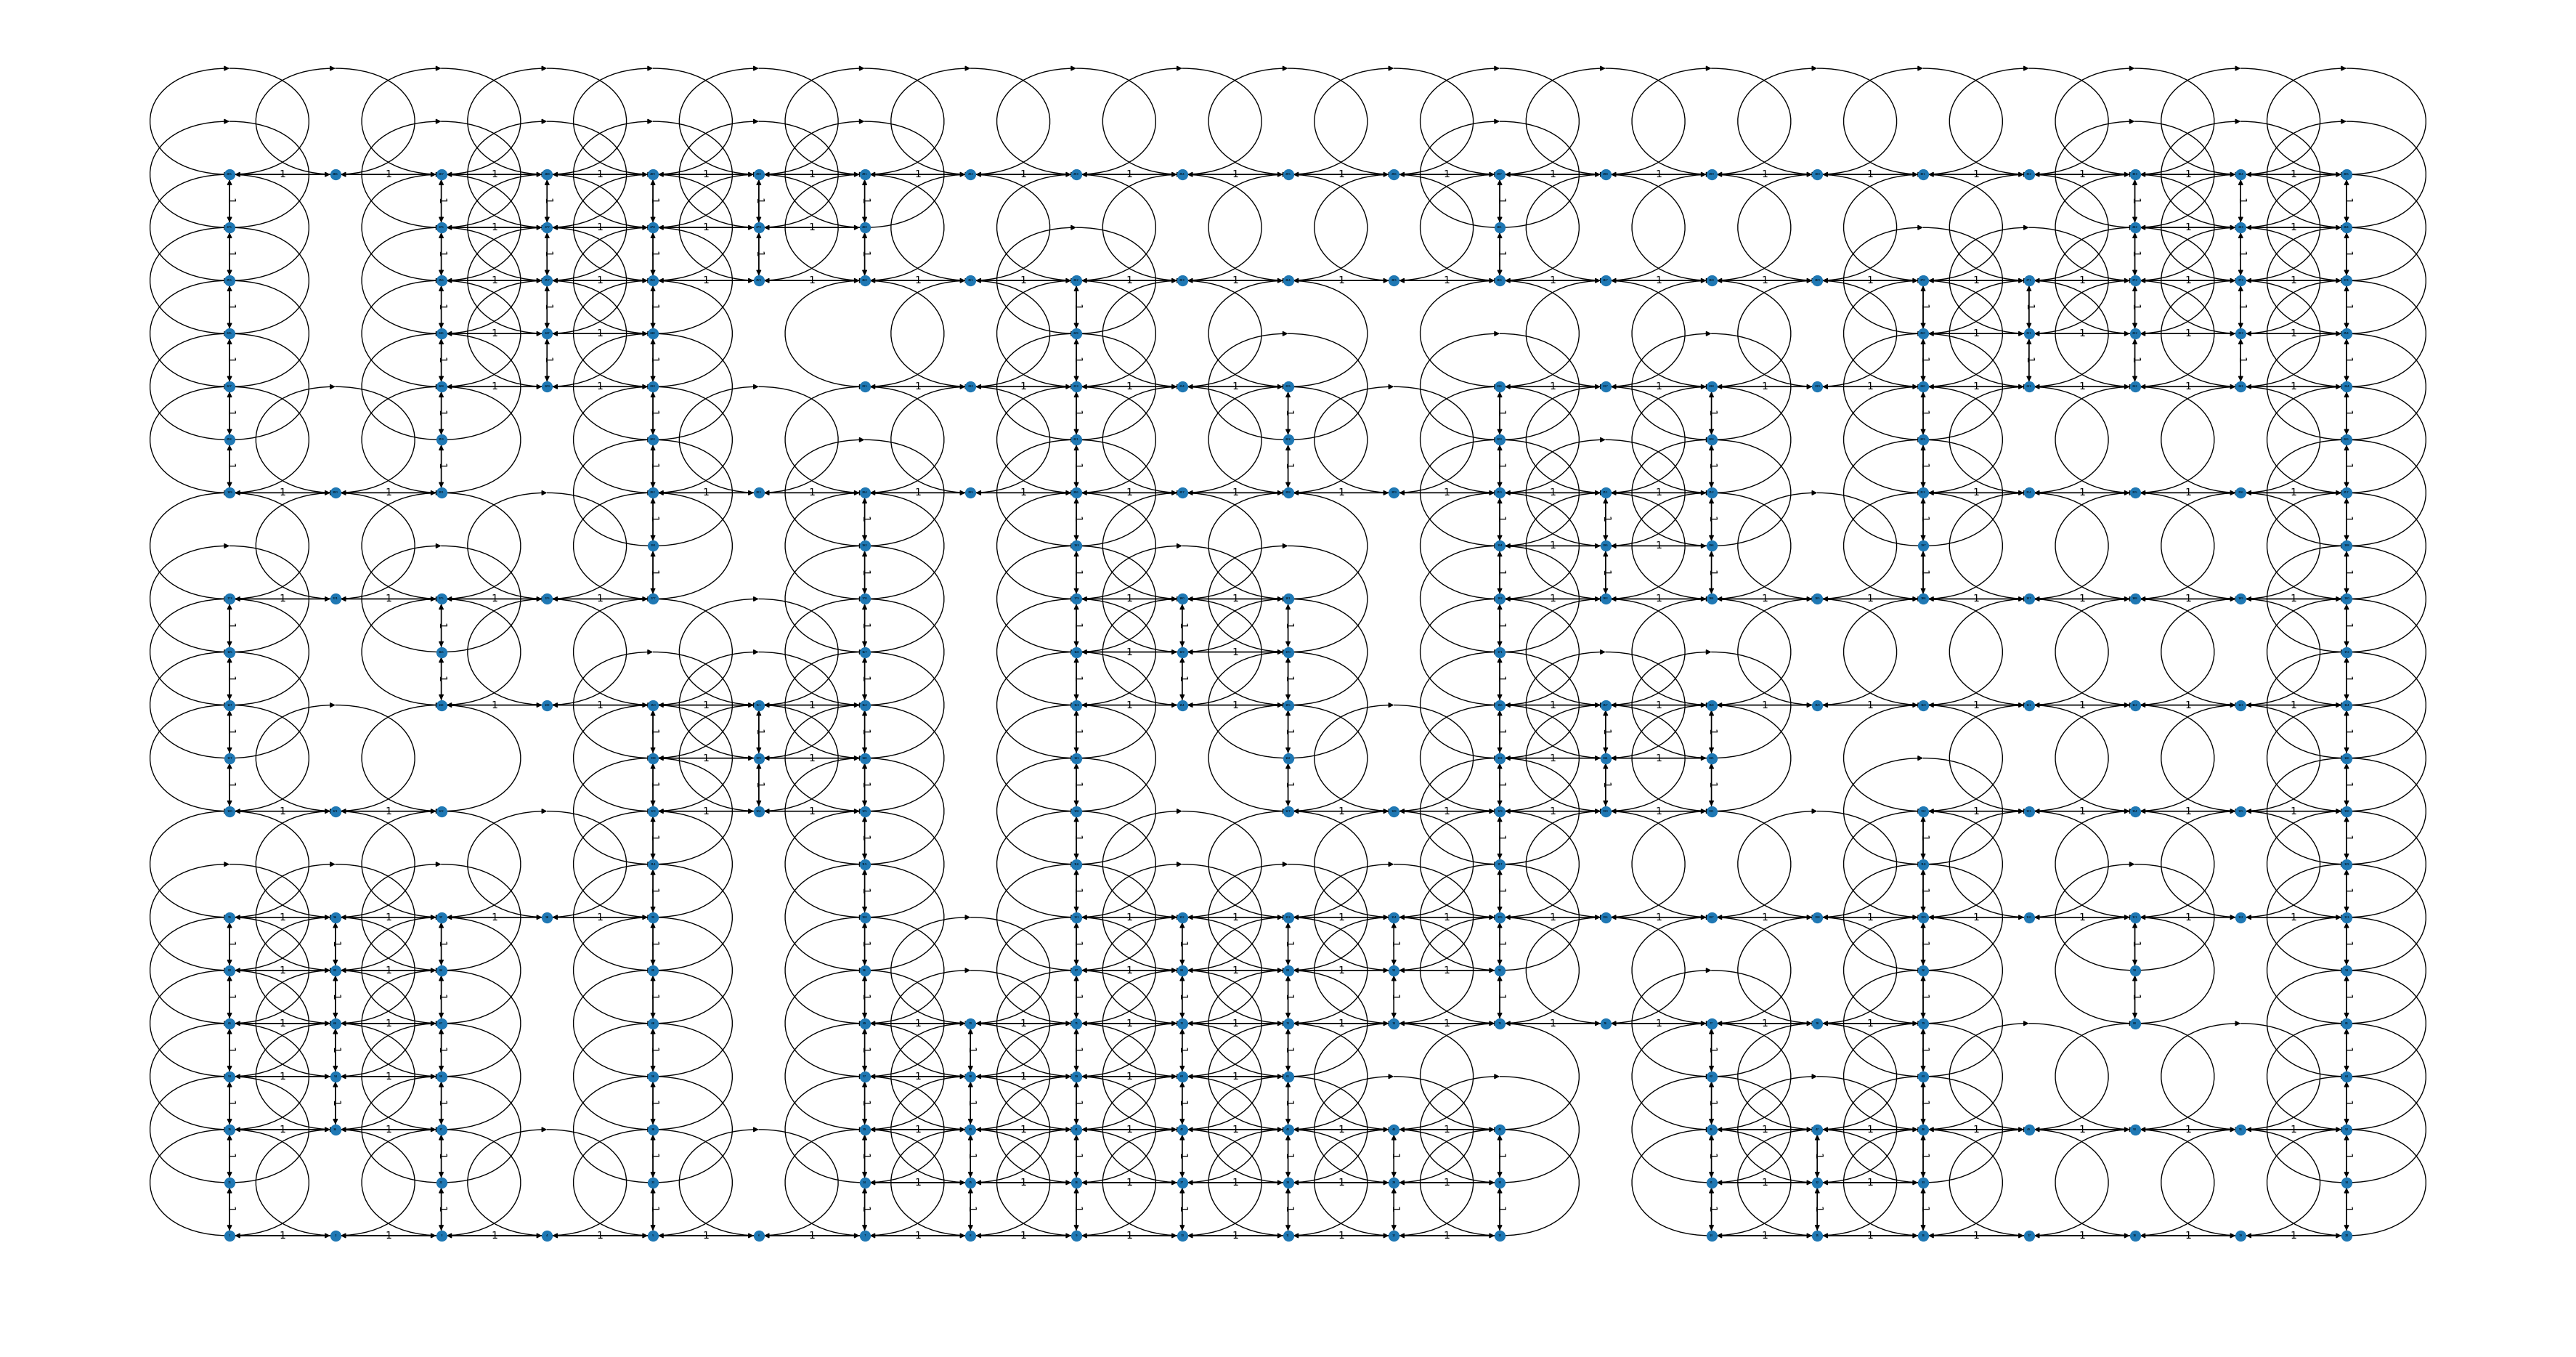

In [18]:
# G= getGraphFromJson("Berlin_1_256_00/0.json")
G= getGraphFromJson("validation-mazes-seed-000/0.json")

In [ ]:
def main_function(filename,G):
    with open(filename, "r") as file:
        data = json.load(file)

    if not nx.is_strongly_connected(G):
        connect_graph(G)


    agents = data.get("agents", [])
    num_nodes=data.get("nNodes")
    agent_list = []
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))


    for agent in agents:
        agent_list.append(Agent(agent,num_nodes,shortest_path_lengths,"wh"))

    for agent in agent_list:
        
        print(nx.shortest_path(G, agent.get_current_pos(), agent.get_end_pos(), weight='weight'))

    # Initialize model
    num_nodes = num_nodes
    input_dim = 7  # Example features per node
    hidden_dim = num_nodes  # Embedding size

    adj_matrix = nx.adjacency_matrix(G).todense()
    adj_matrix = torch.tensor(adj_matrix).float()
    adj_matrix = adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
    model = HebbianGNN(input_dim, hidden_dim, eta=0.1,adj_matrix=adj_matrix)
    models = []
    for agent in agent_list:
        print(agent.get_end_pos())

    n_episodes=1
    # Train the model

    train_hebbian(model, agent_list, G,num_nodes,epochs=n_episodes)
    return agent_list,model

def main_eval_function(filename,G,model):
    with open(filename, "r") as file:
        data = json.load(file)
    
    agents_removed = data.get("agents", [])
    num_nodes=data.get("nNodes")
    agent_list_removed = []
    
    G_modified= G.copy()
    num_edges_to_remove = int(0.1* G.number_of_edges())  # Specify the number of edges to remove
    G_modified = remove_random_edges_while_connected(G_modified, num_edges_to_remove)
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G_modified))

    for agent in agents_removed:
        agent_list_removed.append(Agent(agent,num_nodes,shortest_path_lengths,"wh"))
    for agent in agent_list_removed:
        print("agent:", agent.get_id())
        print(nx.shortest_path(G, agent.get_current_pos(), agent.get_end_pos(), weight='weight'))
        print(nx.shortest_path(G_modified, agent.get_current_pos(), agent.get_end_pos(), weight='weight'))



    num_nodes = num_nodes

    adj_matrix = nx.adjacency_matrix(G_modified).todense()
    adj_matrix = torch.tensor(adj_matrix).float()
    adj_matrix = adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")

    for agent in agent_list_removed:
        print(agent.get_end_pos())
    
    n_episodes=1
    train_hebbian(model, agent_list_removed, G_modified,num_nodes,epochs=n_episodes)
    return agent_list_removed,G_modified

def create_metrics(agents,agents_removed,G,G_modified):
    data=[]
    success_rate = 0
    path_len = np.zeros(len(agents))
    optimal_path_len = np.zeros(len(agents))
    for i,agent in enumerate(agents):
        if agent.get_prev_path()[-1] == agent.get_end_pos():
            success_rate += 1
        path_len[i] = len(agent.get_prev_path()) - 1
        optimal_path_len[i] = nx.shortest_path_length(G,agent.get_prev_path()[0], agent.get_end_pos(), weight='weight')
    
    success_rate /= len(agents)   
    print("Success rate:", success_rate)
    diff_path_len = np.abs(path_len - optimal_path_len)
    avg_path_len = np.mean(diff_path_len)
    data.append(success_rate*100)
    opt_path_mean=np.mean(optimal_path_len)
    print("Average path length difference:", abs(avg_path_len/opt_path_mean)*100)
    data.append(abs(avg_path_len/opt_path_mean)*100)

    makespan = np.max(path_len)
    print("Makespan:", makespan)
    data.append(makespan)
    collisions= 0
    agents_path=[agent.get_prev_path() for agent in agents]
    max_length = max(len(path) for path in agents_path)
    padded_paths = np.array([np.pad(path, (0, max_length - len(path)), 'edge') for path in agents_path])
    for i in range(padded_paths.shape[1]):
        col = padded_paths[:, i]
        unique_elements, counts = np.unique(col, return_counts=True)
        duplicates = np.sum(counts[counts > 1] - 1)
        collisions += duplicates        
    coordination= 1 - (collisions / (len(agents)*makespan))
    print("Collisions:", collisions)
    print("Coordination:", coordination)
    data.append(collisions*100)
    data.append(coordination*100)



    ood_result=0
    path_len = np.zeros(len(agents_removed))
    optimal_path_len = np.zeros(len(agents_removed))
    for i,agent in enumerate(agents_removed):
        if agent.get_prev_path()[-1] == agent.get_end_pos():
            ood_result += 1
        path_len[i] = len(agent.get_prev_path()) - 1
        optimal_path_len[i] = nx.shortest_path_length(G,agent.get_prev_path()[0], agent.get_end_pos(), weight='weight')
    
    ood_result /= len(agents_removed) 
    print("ood_result:", ood_result)
    diff_path_len = np.abs(path_len - optimal_path_len)
    avg_ood_path_len = np.mean(diff_path_len)
    avg_opt_len = np.mean(optimal_path_len)
    
    print("ood_avg_path_len:", avg_ood_path_len)
    data.append(ood_result*100)
    data.append(abs(avg_ood_path_len/avg_opt_len)*100)
    
    shortest_path=np.zeros(len(agents))
    actual_path=np.zeros(len(agents))
    for i,agent in enumerate(agents):
        shortest_path[i]=(nx.shortest_path_length(G_modified,agent.get_prev_path()[0], agent.get_end_pos(), weight='weight'))
        actual_path[i]=len(agent.get_prev_path()) - 1
    pathfinding=actual_path/shortest_path
    data.append(np.mean(pathfinding)*100)
    print("Pathfinding:", np.mean(pathfinding))
    labels = ['Success rate', 'Average path length difference', 'Makespan', 'Collisions',"Coordination", 'OOD_success_rate', 'OOD_avg_path_len',"Pathfinding"]
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    data += data[:1]

    # data=data*100
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, data, linewidth=2, label="Example Algorithm")
    ax.fill(angles, data, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.legend(loc='upper right')
    plt.show()

In [54]:
agent_list,model = main_function("validation-mazes-seed-000/1.json")


[286, 275, 255, 245, 227, 228, 229, 219, 201, 202, 203, 191]
[285, 286, 275, 255, 245, 227, 228, 229, 219, 201, 202, 203, 204, 205, 192, 178, 167, 152, 153, 154, 141, 126, 127, 128, 129]
[297, 298, 299, 300, 301, 302, 281, 271, 251, 241, 242, 243, 225, 216, 197, 189, 171, 163, 145, 135, 118, 112, 111, 110, 109, 108, 91, 78, 62]
191
129
62


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

0 [286, 287, 276, 256, 246, 228, 229, 219, 201, 202, 203, 191]
1 [285, 285, 286, 287, 288, 277, 257, 247, 229, 219, 201, 202, 203, 204, 205, 192, 178, 167, 152, 153, 154, 141, 126, 127, 128, 129]
2 [297, 298, 299, 300, 301, 302, 303, 304, 283, 273, 253, 243, 225, 216, 197, 189, 171, 163, 145, 135, 118, 112, 111, 110, 109, 108, 91, 78, 62]


In [55]:
agent_list_removed, G_modified = main_eval_function("validation-mazes-seed-000/1.json",G,model)

agent: 0
[286, 275, 255, 245, 227, 228, 229, 219, 201, 202, 203, 191]
[286, 275, 255, 245, 227, 228, 229, 219, 201, 202, 203, 191]
agent: 1
[285, 286, 275, 255, 245, 227, 228, 229, 219, 201, 202, 203, 204, 205, 192, 178, 167, 152, 153, 154, 141, 126, 127, 128, 129]
[285, 286, 275, 255, 245, 227, 228, 229, 219, 201, 202, 203, 191, 177, 166, 151, 139, 124, 114, 99, 85, 68, 69, 70, 71, 72, 88, 89, 90, 104, 116, 128, 129]
agent: 2
[297, 298, 299, 300, 301, 302, 281, 271, 251, 241, 242, 243, 225, 216, 197, 189, 171, 163, 145, 135, 118, 112, 111, 110, 109, 108, 91, 78, 62]
[297, 296, 280, 265, 264, 263, 262, 261, 248, 232, 220, 205, 204, 203, 191, 177, 166, 151, 139, 124, 114, 99, 85, 68, 69, 70, 71, 72, 88, 89, 73, 74, 75, 76, 77, 78, 62]
191
129
62


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

0 [286, 285, 285, 286, 275, 255, 256, 246, 228, 229, 219, 201, 202, 203, 191]
1 [285, 286, 275, 255, 245, 227, 228, 229, 219, 201, 202, 203, 191, 177, 166, 151, 139, 124, 114, 99, 85, 68, 69, 70, 71, 72, 88, 89, 90, 104, 116, 128, 129]
2 [297, 296, 280, 265, 264, 263, 262, 261, 248, 232, 220, 205, 204, 205, 204, 203, 191, 177, 166, 151, 139, 124, 114, 99, 85, 68, 69, 70, 86, 87, 88, 89, 90, 74, 75, 76, 77, 78, 62]


Success rate: 1.0
Average path length difference: 1.5873015873015872
Makespan: 28.0
Collisions: 0
Coordination: 1.0
ood_result: 1.0
ood_avg_path_len: 7.0
Pathfinding: 0.8530092592592592


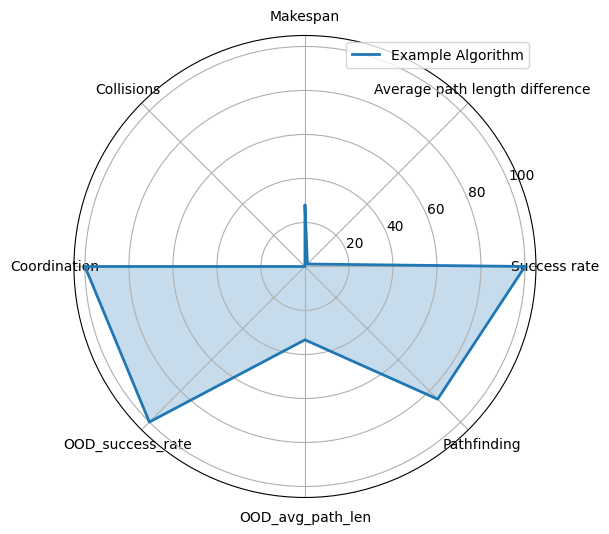

In [60]:
create_metrics(agent_list,agent_list_removed,G,G_modified)